In [1]:
# default_exp data.dataset_factory

In [2]:
from nbdev.export import *

## Utility Functions for Loading Data from OmegaConf config

In [3]:
# export
import albumentations as A
import torchvision.transforms as T
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, Dataset

from src import _logger
from src.data.datasets import CassavaDataset, load_data

In [4]:
# export
def create_transform(cfg: DictConfig, verbose=False):
    "creates transoformations to be used in datasets"
    train_augs_initial = [instantiate(t) for t in cfg.train.before_mix]
    train_augs_final   = [instantiate(t) for t in cfg.train.after_mix]
    valid_augs = [instantiate(t) for t in cfg.valid]
    
    if cfg.backend == "torchvision":
        compose_func = T.Compose
    elif cfg.backend == "albumentations":
        compose_func = A.Compose
    
    train_augs_initial = compose_func(train_augs_initial)
    train_augs_final   = compose_func(train_augs_final)
    valid_augs = compose_func(valid_augs)
    return train_augs_initial, train_augs_final, valid_augs

## Lightning Datamodule -

In [5]:
# export
class CassavaClassificationModule(LightningDataModule):
    "Lightning datamodule for CassavaImageClassification Task"

    def __init__(self, cfg: DictConfig):
        "Note: `cfg` has to be the global hydra config"
        super().__init__()
        self.cfg = cfg
        # split the configuration files
        self.dset_cfg = cfg.data.dataset
        self.tfms_cfg = cfg.augmentations
        self.dls_conf = cfg.data.dataloader
        self.fold = self.dset_cfg.fold

    def prepare_data(self):
        # loads the data correspoind to the current fold
        self.data = load_data(self.dset_cfg.csv, self.dset_cfg.image_dir, self.fold, shuffle=True)
        
        self.train_data = self.data.loc[self.data["is_valid"] == False]
        self.valid_data = self.data.loc[self.data["is_valid"] == True]
        
        self.train_data = self.train_data.sample(frac=1).reset_index(inplace=False, drop=True)
        
        self.valid_data = self.valid_data.sample(frac=1).reset_index(inplace=False, drop=True)

    def setup(self, stage=None, verbose=False):
        if verbose:
            _logger.info("Data processing configuration for current dataset:")
            _logger.info(f"\tinput_size: {cfg.input.input_size}")
            _logger.info(f"\tmean: {tuple(cfg.input.mean)}")
            _logger.info(f"\tstd: {tuple(cfg.input.std)}")
            _logger.info(f"\tinterpolation: {cfg.input.interpolation}")
            
        self.augs_initial, self.augs_final, self.augs_valid = create_transform(self.tfms_cfg)

        # Assign train/val datasets for use in dataloaders

        if self.tfms_cfg.backend == "torchvision":
            self.train_ds = CassavaDataset.from_torchvision_tfms(self.train_data,
                                                                 fn_col="filePath",
                                                                 label_col="label",
                                                                 transform=self.augs_initial)

            self.valid_ds = CassavaDataset.from_torchvision_tfms(self.valid_data,
                                                                 fn_col="filePath",
                                                                 label_col="label",
                                                                 transform=self.augs_valid)

        elif tfm_config.backend == "albumentations":
            self.train_ds = CassavaDataset.from_albu_tfms(self.train_data,
                                                          fn_col="filePath",
                                                          label_col="label",
                                                          transform=self.augs_initial)

            self.valid_ds = CassavaDataset.from_albu_tfms(self.train_data,
                                                          fn_col="filePath",
                                                          label_col="label",
                                                          transform=self.augs_initial)

        # use the same dataset for validation and test
        self.test_ds = self.valid_ds

    def train_dataloader(self):
        return DataLoader(self.train_ds, **self.dls_conf)

    def val_dataloader(self):
        return DataLoader(self.valid_ds, **self.dls_conf)

    def test_dataloader(self):
        return DataLoader(self.test_ds, **self.dls_conf)

In [6]:
from hydra.experimental import initialize, compose
from src.models.builder import Net
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [7]:
with initialize("../conf/"):
    cfg = compose("effnet-base", overrides=['general=default'])
    
cfg.input.mean = IMAGENET_DEFAULT_MEAN
cfg.input.std  = IMAGENET_DEFAULT_STD
cfg.mixmethod.conf_prob = 1.0

In [8]:
dls = CassavaClassificationModule(cfg)
mixmethod = instantiate(cfg.mixmethod)
net = Net(cfg)

dls.prepare_data()
dls.setup()

train_dataloader = dls.train_dataloader()
initial_ims, initial_tgs = next(iter(train_dataloader))
initial_ims = mixmethod(initial_ims, initial_tgs, net)

mixmethod.stop()
dls.train_ds.reload_transforms(dls.augs_final)

train_dataloader = dls.train_dataloader()
_ims, _tgs = next(iter(train_dataloader))
_ims = mixmethod(_ims, _tgs, net)

[01/31 12:53:44 src.models.builder]: Configuration for the current model :
[01/31 12:53:44 src.models.builder]: 	 base_network: tf_efficientnet_b3_ns
[01/31 12:53:44 src.models.builder]: 	 activation: mish
[01/31 12:53:44 src.models.builder]: 	 drop_path_rate: 0.25
[01/31 12:53:44 src.models.builder]: Configuration for model head : 
[01/31 12:53:44 src.models.builder]: 	 class_name: CnnHeadV0
[01/31 12:53:44 src.models.builder]: 	 n_out: 5
[01/31 12:53:44 src.models.builder]: 	 pool_type: avg
[01/31 12:53:44 src.models.builder]: 	 use_conv: False
[01/31 12:53:44 src.models.builder]: 	 act_layer: mish
/Users/ayushman/Desktop/leaf-disease-classification-kaggle/nbs/src/data/mixmethods.py:255: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clslogit = F.softmax(clsw.forward(poolfea))
[01/31 12:54:21 src.data.mixmethods]: Snapmix Stopped .


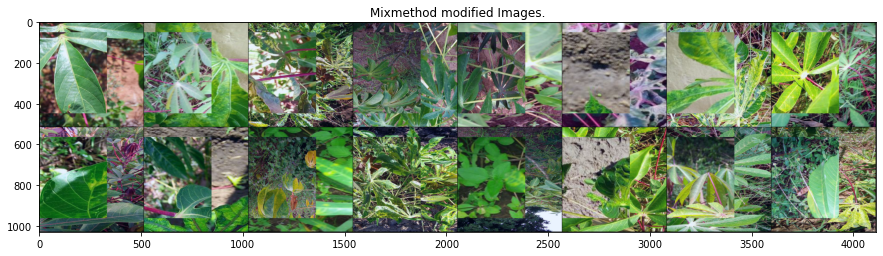

In [9]:
grid = make_grid(initial_ims[:16], normalize=True).permute(1, 2, 0).numpy()

plt.figure(figsize=(15,10))
plt.title("Mixmethod modified Images.")
plt.imshow(grid);

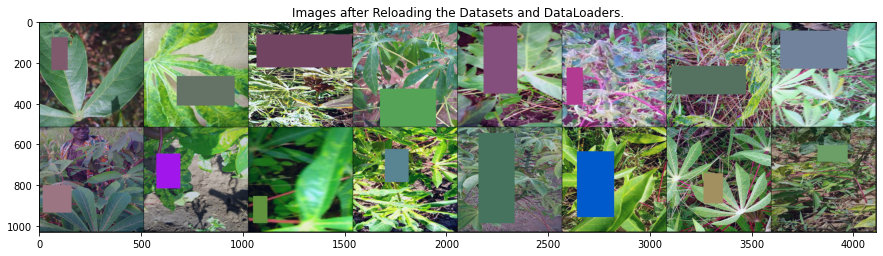

In [10]:
grid = make_grid(_ims[:16], normalize=True).permute(1, 2, 0).numpy()

plt.figure(figsize=(15,10))
plt.title("Images after Reloading the Datasets and DataLoaders.")
plt.imshow(grid);

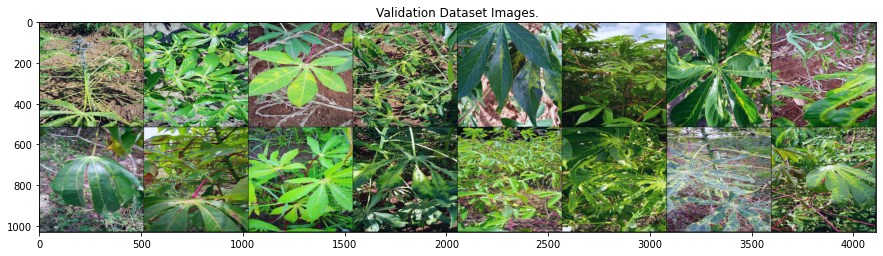

In [11]:
vals = dls.val_dataloader()
val_ims, val_targs = next(iter(vals))

grid = make_grid(val_ims[:16], normalize=True).permute(1, 2, 0).numpy()

plt.figure(figsize=(15,10))
plt.title("Validation Dataset Images.")
plt.imshow(grid);

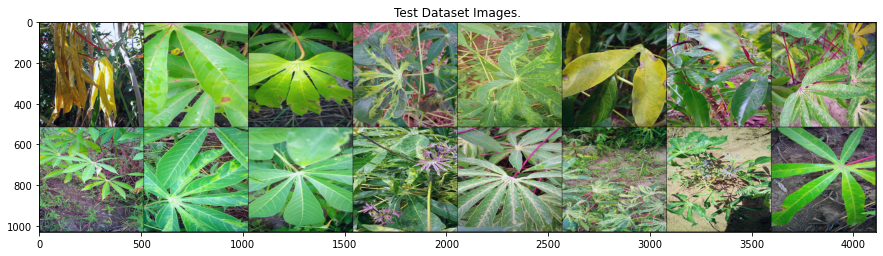

In [69]:
vals = dls.test_dataloader()
val_ims, val_targs = next(iter(vals))

grid = make_grid(val_ims[:16], normalize=True).permute(1, 2, 0).numpy()

plt.figure(figsize=(15,10))
plt.title("Test Dataset Images.")
plt.imshow(grid);

In [12]:
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.datasets.ipynb.
Converted 01a_data.mixmethods.ipynb.
Converted 01b_data.datasests_factory.ipynb.
Converted 02_losses.ipynb.
Converted 03_models.utils.ipynb.
Converted 03a_models.layers.ipynb.
Converted 03b_models.builder.ipynb.
Converted 03b_models.classification.ipynb.
Converted 03b_models.classifiers.ipynb.
Converted 04_optimizers.ipynb.
Converted 04a_schedulers.ipynb.
Converted 05a_lightning.core.ipynb.
Converted 05b_lightning.callbacks.ipynb.
Converted index.ipynb.
